In [16]:
from collections import defaultdict
import itertools
import numpy as np
from benchmark import benchmark_chains
import blackjax
from blackjax.util import run_inference_algorithm
from sampling_algorithms import samplers
from inference_models import models
import jax.numpy as jnp
import math
import pandas as pd
from matplotlib import pyplot as plt
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
from benchmark import get_num_latents
import jax

In [17]:


def run_mclmc(logdensity_fn, num_steps, initial_position, key):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    kernel = blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
    )

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
    )

    return blackjax_mclmc_sampler_params,


def get_optimal_params(model, sampler):

        _, _, params = benchmark_chains(models[model], samplers[sampler], batch=10, n = 5000000, favg=models[model].E_x2, fvar=models[model].Var_x2, only_tune=True)
        return params

In [18]:
def parameter_exploration(model, batch_size, N):

    
    results = defaultdict(float)

    optimal_L, optimal_step_size = get_optimal_params(model, 'mclmc')
    optimal_step_size, optimal_L = optimal_step_size.mean().item(), optimal_L.mean().item()

    # print(optimal_step_size, optimal_L, "\n\n\n\n")

    # optimal_step_size, optimal_L = 1.005, 16.765137 # TODO: remove

    def sampler_mclmc(step_size, L, noise):
        def s(logdensity_fn, num_steps, initial_position, key, only_tune=False):
            alg = blackjax.mclmc(
            logdensity_fn=logdensity_fn,
            step_size=step_size,
            L=L,
            noise=noise
            )
            _, out, info = run_inference_algorithm(
            rng_key=key,
            initial_state_or_position=initial_position,
            inference_algorithm=alg,
            num_steps=num_steps, 
            transform=lambda x: x.position, 
            progress_bar=True)
            return out, 1, MCLMCAdaptationState(L, step_size)

        return s

    # for model in ["simple"]:
        # for step_size, L, noise, N in itertools.product([1.005], [16.765137], [1., 2.], np.linspace(100000.,2000000., 8)):
        #     N = N.astype(int)
        #     _, bias = benchmark_chains(models[model], 
        # (step_size, L, noise), batch=batch_size, n=N,favg=models[model].E_x2, fvar=models[model].Var_x2) #not using fvar and favg
        #     results[(model, step_size, L, noise, N)] = bias

    for step_size, L, noise, num_steps in itertools.product([optimal_step_size], [optimal_L], np.linspace(1e-1, 2, 20), [N]):
        _, bias, _ = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=num_steps,favg=models[model].E_x2, fvar=models[model].Var_x2) #not using fvar and favg
        results[(model, step_size, L, noise, N)] = bias

    for step_size, L, noise, num_steps in itertools.product(np.linspace(0.1,2, 10), [optimal_L], [0.0], [N]):
        _, bias, _ = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=num_steps,favg=models[model].E_x2, fvar=models[model].Var_x2) #not using fvar and favg
        results[(model, step_size, L, noise, N)] = bias

    return results, optimal_step_size, optimal_L



In [19]:
batch_size = 10
N = 1000000
model = "normal"
results, optimal_step_size, optimal_L = parameter_exploration(model, batch_size=batch_size, N=N)


params MCLMCAdaptationState(L=Array(2.6999369, dtype=float32), step_size=Array(3.1701992, dtype=float32))
params MCLMCAdaptationState(L=Array(2.6672904, dtype=float32), step_size=Array(3.4891348, dtype=float32))
params MCLMCAdaptationState(L=Array(2.652892, dtype=float32), step_size=Array(3.7058399, dtype=float32))
params MCLMCAdaptationState(L=Array(2.665174, dtype=float32), step_size=Array(3.5908537, dtype=float32))
params MCLMCAdaptationState(L=Array(2.6692078, dtype=float32), step_size=Array(3.4893663, dtype=float32))
params MCLMCAdaptationState(L=Array(2.6660128, dtype=float32), step_size=Array(3.5770564, dtype=float32))
params MCLMCAdaptationState(L=Array(2.665293, dtype=float32), step_size=Array(3.313375, dtype=float32))
params MCLMCAdaptationState(L=Array(2.667361, dtype=float32), step_size=Array(3.5413756, dtype=float32))
params MCLMCAdaptationState(L=Array(2.6546621, dtype=float32), step_size=Array(3.6982584, dtype=float32))
params MCLMCAdaptationState(L=Array(2.6687863, dtyp






AVG NUM STEPS PER TRAJ 1.0
crossing 148 296.0 0.33783785
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-2.2809085e-04  3.0484589e-04 -7.7716890e-05 -1.0580686e-04
  7.9490732e-05  6.1487983e-04  1.6509840e-04 -1.1962621e-04
  7.3107862e-04  1.3235038e-04]
Empirical std [0.99061847 0.99110883 0.99103516 0.9914405  0.99122113 0.99153095
 0.99088037 0.9909325  0.99062836 0.99138343]







AVG NUM STEPS PER TRAJ 1.0
crossing 149 298.0 0.33557048
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-2.2562906e-04  3.6186047e-04 -9.9944482e-05 -8.3058236e-05
  9.0861278e-05  6.1669800e-04  1.5625553e-04 -5.6738263e-05
  7.0496800e-04  9.5432901e-05]
Empirical std [0.99242574 0.99287957 0.9928617  0.9932199  0.99303794 0.99335945
 0.9927753  0.9927596  0.9924185  0.99320906]







AVG NUM STEPS PER TRAJ 1.0
crossing 151 302.0 0.33112583
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-2.2926895e-04  4.2248974e-04 -1.2642758e-04 -6.1120707e-05
  9.6072501e-05  6.1848556e-04  1.4829570e-04  2.0829239e-06
  6.8594422e-04  5.3149193e-05]
Empirical std [0.9954401  0.99585265 0.99587554 0.9961925  0.99605787 0.9963839
 0.9958715  0.9958009  0.9954182  0.99622667]







AVG NUM STEPS PER TRAJ 1.0
crossing 154 308.0 0.32467532
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-2.3784080e-04  4.8322891e-04 -1.5646515e-04 -3.9706043e-05
  9.4950010e-05  6.2167092e-04  1.4194037e-04  5.4016706e-05
  6.7306048e-04  6.2448976e-06]
Empirical std [0.99963623 1.0000049  1.0000554  1.0003341  1.0002533  1.0005776
 1.0001384  1.000032   0.9996033  1.0004121 ]







AVG NUM STEPS PER TRAJ 1.0
crossing 157 314.0 0.31847134
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-2.5008994e-04  5.4125447e-04 -1.8853255e-04 -1.8839228e-05
  8.8082241e-05  6.2665774e-04  1.3692629e-04  9.7793156e-05
  6.6455023e-04 -4.3632070e-05]
Empirical std [1.00498   1.0053039 1.0053728 1.0056138 1.0055882 1.0059049 1.0055387
 1.0054162 1.0049393 1.005733 ]







AVG NUM STEPS PER TRAJ 1.0
crossing 163 326.0 0.30674848
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-2.6506712e-04  5.9471361e-04 -2.2081334e-04  1.4400116e-06
  7.5903874e-05  6.3242868e-04  1.3185506e-04  1.3396530e-04
  6.5856415e-04 -9.4400340e-05]
Empirical std [1.0114306 1.0117072 1.0117902 1.0119933 1.0120192 1.0123237 1.0120299
 1.0119083 1.0113823 1.0121491]







AVG NUM STEPS PER TRAJ 1.0
crossing 178 356.0 0.28089887
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-2.8222002e-04  6.4304279e-04 -2.5186618e-04  2.1530768e-05
  5.8431477e-05  6.3739822e-04  1.2485287e-04  1.6447324e-04
  6.5318955e-04 -1.4430887e-04]
Empirical std [1.0189401 1.0191667 1.0192627 1.0194286 1.019498  1.0197868 1.0195647
 1.0194566 1.0188819 1.0196148]







AVG NUM STEPS PER TRAJ 1.0
crossing 224 448.0 0.22321428
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-3.0126274e-04  6.8681961e-04 -2.8108418e-04  4.2145246e-05
  3.5715020e-05  6.4036541e-04  1.1442246e-04  1.9193867e-04
  6.4643548e-04 -1.9253191e-04]
Empirical std [1.0274543 1.02763   1.0277383 1.027869  1.0279726 1.0282443 1.0280924
 1.0280058 1.0273831 1.0280797]







AVG NUM STEPS PER TRAJ 1.0
crossing 281 562.0 0.17793594
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-3.2180999e-04  7.2709023e-04 -3.0850625e-04  6.3835352e-05
  8.3313234e-06  6.4079091e-04  9.9776058e-05  2.1894273e-04
  6.3651439e-04 -2.3918808e-04]
Empirical std [1.036916  1.037042  1.0371599 1.0372598 1.0373884 1.0376425 1.0375583
 1.0374982 1.0368284 1.0374893]







AVG NUM STEPS PER TRAJ 1.0
crossing 470 940.0 0.10638298
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-3.4318614e-04  7.6477963e-04 -3.3451649e-04  8.6751206e-05
 -2.2649891e-05  6.3862355e-04  8.0728911e-05  2.4742106e-04
  6.2207266e-04 -2.8494548e-04]
Empirical std [1.0472652 1.0473466 1.0474684 1.047543  1.0476888 1.047926  1.0479066
 1.0478748 1.0471592 1.0477858]







AVG NUM STEPS PER TRAJ 1.0
crossing 945 1890.0 0.052910052
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-3.64538137e-04  8.00532696e-04 -3.59663187e-04  1.10750894e-04
 -5.60006229e-05  6.34049589e-04  5.75900631e-05  2.78366613e-04
  6.02350687e-04 -3.30633658e-04]
Empirical std [1.0584413 1.058485  1.0586032 1.0586587 1.058816  1.0590369 1.05908
 1.0590757 1.0583155 1.0589097]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-3.8500395e-04  8.3477923e-04 -3.8453561e-04  1.3565633e-04
 -9.0572903e-05  6.2734220e-04  3.1082305e-05  3.1189623e-04
  5.7721371e-04 -3.7690924e-04]
Empirical std [1.0703835 1.0703982 1.0705043 1.0705465 1.0707113 1.0709165 1.0710202
 1.0710412 1.0702384 1.0708007]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-4.0390342e-04  8.6779433e-04 -4.0964625e-04  1.6138880e-04
 -1.2535001e-04  6.1883562e-04  2.1404908e-06  3.4755337e-04
  5.4703717e-04 -4.2409307e-04]
Empirical std [1.0830323 1.0830272 1.0831132 1.0831472 1.083316  1.0835065 1.08367
 1.083713  1.0828683 1.0833989]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-4.2083330e-04  8.9970324e-04 -4.3533472e-04  1.8799276e-04
 -1.5944555e-04  6.0892757e-04 -2.8329041e-05  3.8463168e-04
  5.1249668e-04 -4.7219484e-04]
Empirical std [1.096329  1.0963134 1.0963717 1.0964018 1.0965726 1.0967482 1.096972
 1.0970331 1.096148  1.0966465]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-4.3565567e-04  9.3052303e-04 -4.6176222e-04  2.1557276e-04
 -1.9214083e-04  5.9803686e-04 -5.9601087e-05  4.2241171e-04
  4.7437724e-04 -5.2102021e-04]
Empirical std [1.1102171 1.1101989 1.1102238 1.1102527 1.1104246 1.1105852 1.1108698
 1.1109453 1.1100202 1.1104865]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-4.4844445e-04  9.6024398e-04 -4.8894802e-04  2.4422540e-04
 -2.2291396e-04  5.8655086e-04 -9.1175076e-05  4.6030068e-04
  4.3343444e-04 -5.7027605e-04]
Empirical std [1.1246423 1.1246278 1.1246146 1.1246451 1.1248173 1.1249619 1.1253086
 1.1253952 1.1244301 1.1248647]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-0.00045943  0.00098888 -0.00051681  0.00027399 -0.00025144  0.0005748
 -0.00012274  0.00049789  0.00039032 -0.00061965]
Empirical std [1.1395509 1.1395463 1.139491  1.1395247 1.1396977 1.1398252 1.1402355
 1.1403292 1.1393247 1.1397277]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-0.00046892  0.0010165  -0.00054521  0.00030482 -0.00027759  0.00056304
 -0.0001541   0.00053498  0.00034555 -0.00066886]
Empirical std [1.1548933 1.1549022 1.1548023 1.1548406 1.1550153 1.1551243 1.1555994
 1.1556969 1.154653  1.1550256]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-0.00047727  0.00104318 -0.00057397  0.00033663 -0.00030136  0.00055147
 -0.00018514  0.00057149  0.00029954 -0.0007177 ]
Empirical std [1.1706208 1.1706468 1.1705004 1.170544  1.1707219 1.1708107 1.1713514
 1.1714495 1.1703668 1.1707097]







AVG NUM STEPS PER TRAJ 1.0
crossing 1000000 2000000.0 5e-05
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-0.0004848   0.00106904 -0.00060286  0.00036928 -0.00032285  0.00054025
 -0.00021578  0.00060746  0.00025263 -0.00076603]
Empirical std [1.1866876 1.1867332 1.186539  1.1865888 1.1867713 1.1868383 1.1874455
 1.187541  1.1864201 1.1867346]







AVG NUM STEPS PER TRAJ 1.0
crossing 5098 10196.0 0.009807767
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-0.00517157  0.0033375  -0.00277036  0.00094238  0.00101887  0.00404391
  0.00173481 -0.00141812  0.00518671 -0.00064059]
Empirical std [0.9970813  0.999122   0.9999793  0.9998869  0.99965155 1.0011384
 0.9989518  1.0010053  0.99719125 1.0004852 ]







AVG NUM STEPS PER TRAJ 1.0
crossing 1614 3228.0 0.030978935
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-3.1005493e-03  1.6717432e-03 -8.9743134e-04  3.6965369e-04
 -2.0134190e-04  1.4257021e-03  1.4112346e-03 -4.3249610e-04
  3.5307277e-03 -1.7519251e-05]
Empirical std [0.9986154  0.9990737  0.9998045  0.998701   0.9996646  1.0013961
 0.9999164  1.000503   0.99868125 0.99924606]







AVG NUM STEPS PER TRAJ 1.0
crossing 1207 2414.0 0.04142502
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-0.00235638  0.0006095  -0.00118497 -0.00016125  0.0002506   0.00070704
  0.0011249   0.00013894  0.00184033 -0.00043693]
Empirical std [0.99985516 0.99914473 1.0000725  0.99941516 0.9989999  1.0022051
 0.9995157  1.0003458  0.99973494 0.9995824 ]







AVG NUM STEPS PER TRAJ 1.0
crossing 881 1762.0 0.056753688
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-1.6800432e-03  6.9217838e-04 -1.0210219e-03 -1.4218417e-04
  5.6921632e-05  3.8692757e-04  9.5749588e-04  4.5366987e-04
  1.5441774e-03 -1.6616362e-04]
Empirical std [1.0001007  0.99900895 1.000057   0.99938196 0.99877226 1.0018756
 0.9996039  1.0003756  0.99970293 0.9994411 ]







AVG NUM STEPS PER TRAJ 1.0
crossing 732 1464.0 0.068306014
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-1.3283389e-03  8.7600946e-04 -1.1297214e-03 -1.8353338e-04
 -7.8030665e-05  5.1508093e-04  7.8580511e-04  2.3892212e-04
  1.4049847e-03  6.6758963e-05]
Empirical std [0.9999805  0.9984225  0.9999135  0.9995559  0.9983493  1.0012746
 0.99966615 1.000035   0.99936604 0.99928176]







AVG NUM STEPS PER TRAJ 1.0
crossing 624 1248.0 0.08012821
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-1.0713448e-03  8.2502142e-04 -1.1101416e-03 -1.7456646e-04
 -6.8566651e-06  6.3027977e-04  6.4618886e-04  1.4510592e-04
  1.3310667e-03  1.6772308e-04]
Empirical std [0.9997317  0.9980485  0.99968654 0.99939996 0.9980553  1.0006541
 0.9995685  0.9995722  0.99892986 0.999081  ]







AVG NUM STEPS PER TRAJ 1.0
crossing 567 1134.0 0.08818342
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-1.0326314e-03  7.7568978e-04 -9.6391857e-04 -1.0795182e-04
  7.7747245e-05  7.5978314e-04  6.0725876e-04  6.1879742e-05
  1.3337256e-03  1.9354526e-04]
Empirical std [0.9992882  0.99778277 0.9991286  0.9990503  0.99787426 1.0000976
 0.99925125 0.9990886  0.9985852  0.9987479 ]







AVG NUM STEPS PER TRAJ 1.0
crossing 517 1034.0 0.0967118
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-9.7262987e-04  7.9279311e-04 -8.5106486e-04 -6.6407774e-05
  1.6041775e-04  7.9047697e-04  6.0318207e-04 -5.7894595e-05
  1.2262295e-03  2.7220068e-04]
Empirical std [0.9986879  0.99747455 0.99850667 0.9986404  0.9976671  0.9995425
 0.9987544  0.9986034  0.99813664 0.9983506 ]







AVG NUM STEPS PER TRAJ 1.0
crossing 421 842.0 0.11876485
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-8.2940538e-04  8.3722023e-04 -7.8672444e-04 -5.1147646e-05
  1.4067370e-04  7.9853489e-04  5.4690952e-04 -1.2589480e-04
  1.1076768e-03  3.2644454e-04]
Empirical std [0.99805915 0.9971509  0.9979524  0.9982003  0.9974034  0.9989581
 0.99819356 0.9980555  0.9976001  0.99791026]







AVG NUM STEPS PER TRAJ 1.0
crossing 278 556.0 0.17985612
True mean [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical mean [-6.5562845e-04  7.9916429e-04 -6.9301506e-04 -5.5023749e-05
  8.8572961e-05  8.2613516e-04  4.6081480e-04 -1.6834887e-04
  1.0205342e-03  3.2615586e-04]
Empirical std [0.997379   0.99673295 0.9973893  0.99774677 0.99702686 0.9983093
 0.99757224 0.9974398  0.99702024 0.9974102 ]


/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


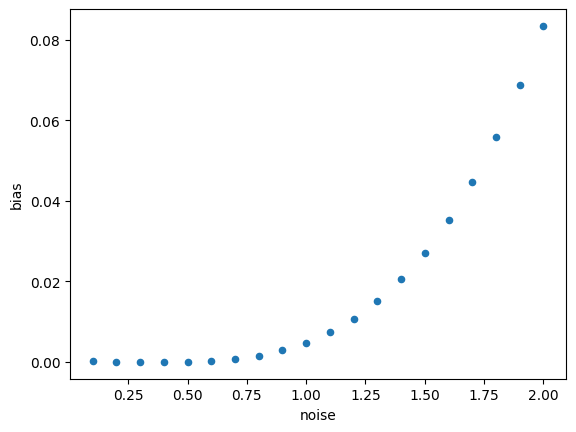

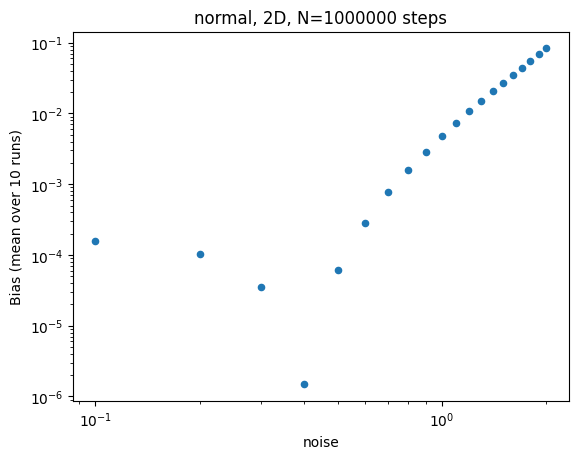

In [20]:
df = pd.Series(results).reset_index()
df.columns = ["model", "step_size", "L", "noise", "N", "bias"] 

df_1 = df[df.N==N]
df_1 = df_1[df_1.model==model]
df_1 = df_1[df_1.step_size==optimal_step_size]
df_1 = df_1[df_1.L==optimal_L]
df_1

df_1.plot.scatter(x="noise", y="bias", colormap='viridis', )
df_1.plot.scatter(x="noise", y="bias", colormap='viridis', loglog=True)
plt.xlabel('noise')
plt.ylabel(f'Bias (mean over {batch_size} runs)')
plt.title(f'{model}, 2D, N={N} steps')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


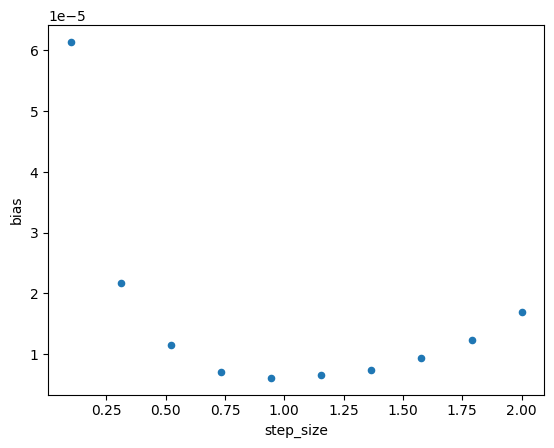

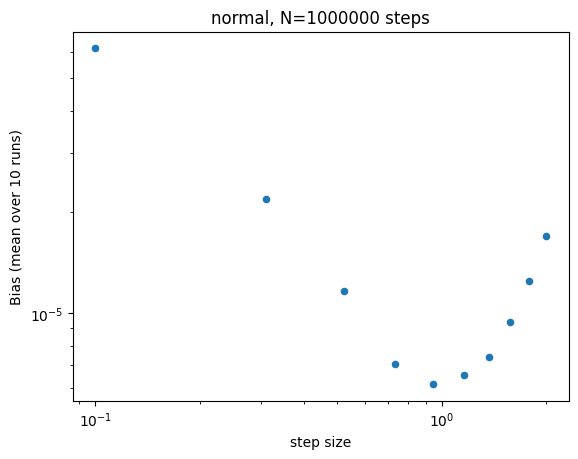

In [21]:
df_2 = df[df.N==N]
df_2 = df_2[df_2.model==model]
df_2 = df_2[df_2.noise==0.0]
df_2 = df_2[df_2.L==optimal_L]
df_2

df_2.plot.scatter(x="step_size", y="bias", colormap='viridis')
df_2.plot.scatter(x="step_size", y="bias", colormap='viridis', loglog=True)
plt.xlabel('step size')
plt.ylabel(f'Bias (mean over {batch_size} runs)')
plt.title(f'{model}, N={N} steps')
plt.show()


In [14]:
# df_3 = df
# df_3 = df_3[df_3['N'] > 1000000]
# df_3 = df_3[df_3.model=="Banana"]
# df_3 = df_3[df_3.step_size==1.005]
# df_3 = df_3[df_3.L==16.765137]
# df_3


# df_3.plot.scatter(x="N", y="bias", colormap='viridis', c='noise')
# plt.xlabel('N')
# plt.ylabel(f'Bias (mean over {batch_size} runs)')
# plt.title(f'Banana, 2D, step size=1.005, L=16.765137')
# plt.show()